In [1]:
#Define an n x n grid size around your tropical wave to extract data from (we'll average the values) 
# 3. Set window size (number of grid points on each side of center)
half_n = 2  # For a 5x5 box → 2 on each side + center

#FOR NOW 
dt_cckw_cross_hrs = 0


In [149]:
# Import relevant packages


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import random
import nbformat
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint
import csv
import sage 
from sage import PermutationEstimator

In [3]:

# # Load the notebook
# with open("post_process_tc_wave_cckw_interactions_automated.ipynb") as f:
#     nb = nbformat.read(f, as_version=4)

# # Get the code from the cells
# code_cells = [cell['source'] for cell in nb.cells if cell.cell_type == 'code']

# # Execute a specific cell (e.g., cell 3) to get the variable
# exec(code_cells[0])  # Be careful: this executes code!

# # Now the variable from that cell will be in your namespace
# print(dt_cckw_cross_hrs)  # Assuming cell 3 defines `my_variable`

In [4]:
merged_cckw = pd.read_csv('merged_cckw.csv')
merged_cckw

,ID,fhr,time,lon,lat,vor850,day_adj,cckw_crest_cross,tc_genesis,developer
0,139,138.0,2000-04-04 18:00:00,278.625671,8.888637,3.522798,6.25,0.0,0.0,1.0
1,413,186.0,2000-04-06 18:00:00,198.612503,6.923033,2.540011,8.25,0.0,0.0,1.0
2,774,318.0,2000-04-12 06:00:00,162.555420,11.464490,4.961282,13.75,0.0,0.0,1.0
3,907,522.0,2000-04-20 18:00:00,237.747238,9.135058,3.187877,22.25,0.0,0.0,1.0
4,1060,498.0,2000-04-19 18:00:00,47.579945,7.618085,4.137427,21.25,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
223,6073,2844.0,2000-07-26 12:00:00,265.664886,19.568724,2.247950,119.00,0.0,0.0,0.0
224,6113,2760.0,2000-07-23 00:00:00,133.374588,14.434371,0.718992,115.50,0.0,0.0,0.0
225,6279,3018.0,2000-08-02 18:00:00,86.448380,4.810503,2.179097,126.25,0.0,0.0,0.0
226,6302,3084.0,2000-08-05 12:00:00,358.855286,5.776806,1.209360,129.00,0.0,0.0,0.0


In [5]:
#Now let's add key variable anomalies that may be predictive of tc genesis at the track's center. Let's make sure we do this systematically! 

#Key variables (for now)
key_vars ={'olrtoa','mse_vint','u200','v200','u850','v850','qv_vint'}

#What I want to do: 
#1) For each row in merged_cckw, find nearest lat-lon-time data point 
#2) Find the value of the key variables at that point in space and time 
#3) Anomalies must be created - we can do this by averaging all the data points at that latitude (for all longtiude and time values) for those key variables 
#4) Add those anomaly columns to the merged_cckw dataframe 


In [6]:
exp_name = 'TC_3km'
pth = "/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N/%s/"%exp_name
fname = pth+'latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
ds = xr.open_dataset(fname)
ds

<xarray.Dataset> Size: 90GB
Dimensions:   (time: 538, lon: 3600, lat: 552)
Coordinates:
  * time      (time) datetime64[ns] 4kB 2000-03-29T12:00:00 ... 2000-08-10T18...
  * lon       (lon) float64 29kB 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * lat       (lat) float64 4kB -14.95 -14.85 -14.75 ... 39.95 40.05 40.15
Data variables: (12/21)
    rainc     (time, lat, lon) float32 4GB ...
    rainnc    (time, lat, lon) float32 4GB ...
    pr        (time, lat, lon) float32 4GB ...
    prc       (time, lat, lon) float32 4GB ...
    hfx       (time, lat, lon) float32 4GB ...
    mse_vint  (time, lat, lon) float32 4GB ...
    ...        ...
    u850      (time, lat, lon) float32 4GB ...
    ushr      (time, lat, lon) float32 4GB ...
    v10       (time, lat, lon) float32 4GB ...
    v200      (time, lat, lon) float32 4GB ...
    v850      (time, lat, lon) float32 4GB ...
    vshr      (time, lat, lon) float32 4GB ...
Attributes:
    Conventions:  CF-1.7

In [7]:
# -----------------------------
# Step 0. Load your data
# -----------------------------
# Open the input dataset (assumes your infile is in a NetCDF-like format)

# The key variables
key_vars = {'olrtoa', 'mse_vint', 'u200', 'v200', 'u850', 'v850', 'qv_vint'}

# -----------------------------
# Step 1. Identify latitudes of interest
# -----------------------------
# Extract unique latitudes from merged_cckw
lat_interest = np.unique(merged_cckw['lat'])
# Print for debugging:
print("Latitudes of interest:", lat_interest)


Latitudes of interest: [-2.11379   0.900047  1.923851  2.043174  2.728995  2.916088  3.094325
  3.188362  3.221646  3.487211  3.642919  3.665281  3.919714  3.97532
  4.149562  4.405801  4.434918  4.525623  4.622905  4.810503  4.814079
  4.826263  4.925997  5.048761  5.079166  5.175823  5.190067  5.199242
  5.23987   5.258481  5.425529  5.534486  5.626326  5.626872  5.639154
  5.673002  5.709276  5.722951  5.727172  5.762957  5.776806  5.855659
  5.974441  6.019614  6.05166   6.188488  6.224133  6.313917  6.327643
  6.457926  6.479525  6.515817  6.563504  6.587044  6.613551  6.635245
  6.696631  6.720313  6.734026  6.797878  6.839622  6.90836   6.922534
  6.923033  6.936582  6.954613  6.969622  6.985094  7.023653  7.026378
  7.129595  7.30258   7.3837    7.454962  7.495808  7.497995  7.534088
  7.576272  7.5958    7.618085  7.668938  7.717054  7.808681  7.813634
  7.822735  7.905107  7.930477  7.961646  7.971119  7.98055   8.014495
  8.083918  8.213318  8.231096  8.280962  8.28397   8.3

In [8]:
#So this could use some work. First, I should run this for the entire dataset so I have values at all latitudes. Then I need to best map the latitudes of interest to this. 


# # -----------------------------
# # Step 2. Compute background means only for these latitudes
# # -----------------------------
# # Create a dictionary to hold the background (mean) for each variable
# avg_dict = {}
# for var in key_vars:
#     # Compute the mean over time and lon, then select only latitudes of interest
#     avg_mean = ds[var].mean(dim=['time', 'lon'])
#     # Only take values corresponding to latitudes of interest 
#     # (using method='nearest' to match if the latitudes don't exactly coincide)
#     avg_dict[var] = avg_mean.sel(lat=lat_interest, method='nearest')

#SAVE OFF AS NETCDF! 

In [9]:
#load key variables averages dataset generated previously 
avg_ds = xr.open_dataset('lat_avg_values_aquaplanet.nc')

# Step 1: Get the latitude values
lat_vals = avg_ds['lat'].values

# Step 2: Identify unique latitudes and their first index positions
_, unique_indices = np.unique(lat_vals, return_index=True)

# Step 3: Sort those indices to preserve original order
unique_indices_sorted = np.sort(unique_indices)

# Step 4: Select only those unique indices along the lat dimension
avg_ds_non_duplicated = avg_ds.isel(lat=unique_indices_sorted)

avg_ds_non_duplicated

<xarray.Dataset> Size: 53kB
Dimensions:                        (lat: 552)
Coordinates: (12/22)
  * lat                            (lat) float64 4kB -14.95 -14.85 ... 40.15
    rainc                          (lat) float32 2kB ...
    rainnc                         (lat) float32 2kB ...
    pr                             (lat) float32 2kB ...
    prc                            (lat) float32 2kB ...
    hfx                            (lat) float32 2kB ...
    ...                             ...
    u850                           (lat) float32 2kB ...
    ushr                           (lat) float32 2kB ...
    v10                            (lat) float32 2kB ...
    v200                           (lat) float32 2kB ...
    v850                           (lat) float32 2kB ...
    vshr                           (lat) float32 2kB ...
Data variables:
    __xarray_dataarray_variable__  (lat) float32 2kB ...
Attributes:
    __xarray_dataarray_name__:  vshr

In [10]:

def get_index(coord_array, value):
    """
    Get the index of the closest value in a coordinate array.
    Works for both numeric and datetime values.
    """
    # Convert to NumPy array if it's xarray or pandas
    coord_array = np.asarray(coord_array)
    
    # If datetime, cast both to numpy.datetime64
    if np.issubdtype(coord_array.dtype, np.datetime64):
        value = np.datetime64(value,'ns')
        coord_array = coord_array.astype('datetime64[ns]')
    
    return np.abs(coord_array - value).argmin()



def get_raw_values(row):
    values = {}
    for var in key_vars:
        try:
            #THIS WOULD BE FOR SINGLE POINT 
            # Select the nearest point from ds using the values in the current row
            point_val = ds[var].sel(
                time=row['time'],
                lat=row['lat'],
                lon=row['lon'],
                method='nearest'
            )

            # 1. Get the actual matched coordinate from your sel()
            nearest_time = point_val['time'].item()
            nearest_lat = point_val['lat'].item()
            nearest_lon = point_val['lon'].item()

            lat_idx = get_index(ds['lat'].values, nearest_lat)
            lon_idx = get_index(ds['lon'].values, nearest_lon)
            time_idx = get_index(ds['time'].values, nearest_time)

            
            anomaly_values= avg_ds_non_duplicated[var].isel(lat=slice(lat_idx - half_n, lat_idx + half_n + 1) )

            lat_idx_min = lat_idx - half_n
            lat_idx_max = lat_idx + half_n + 1


            

            #Finding longitude indices a bit more complex b/c we need to deal with exceeding ds lon index range. 
            #Wrap longitude indices in case we exceed 3600 or go below 0. 

            lon_idx_min = lon_idx - half_n
            lon_idx_max = lon_idx + half_n
            
            lon_indices = np.linspace(lon_idx_min,lon_idx_max,(lon_idx_max-lon_idx_min)+1).astype(int)
            fixed_lon_indices = lon_indices % 3600 #deal w/ wrap-around using modulo operator
            
            n_by_n_grid_avg_val = ds[var].isel(
            time=time_idx,
            lat=slice(lat_idx_min, lat_idx_max),
            lon=fixed_lon_indices 
            )
            
            #Old code
            #------------------
            # anomaly_values= avg_ds_non_duplicated[var].isel(lat=slice(lat_idx - half_n, lat_idx + half_n + 1) )
            
            # n_by_n_grid_avg_val = ds[var].isel(
            # time=time_idx,
            # lat=slice(lat_idx - half_n, lat_idx + half_n + 1),
            # lon=slice(lon_idx - half_n, lon_idx + half_n + 1)
            # )
            
            n_by_n_grid_avg_val_anomaly = (n_by_n_grid_avg_val - avg_ds_non_duplicated[var]).mean().item()

            # Save the value with a new column name: var'
            values[var + '_anomaly'] = n_by_n_grid_avg_val_anomaly 
            
        except Exception as e:
            print(f"Error for variable {var} at row {row.name}: {e}")
            values[var] = np.nan  # In case of error, fill with NaN
    return pd.Series(values)

# Apply the function row-wise to create a DataFrame of the raw values
raw_values_df = merged_cckw.apply(get_raw_values, axis=1)
print(raw_values_df)

# Append these new columns to the original merged_cckw DataFrame
merged_cckw_full = pd.concat([merged_cckw, raw_values_df], axis=1)

# Show the first few rows of the updated DataFrame to verify:
print(merged_cckw_full.head())

     qv_vint_anomaly  u200_anomaly  u850_anomaly  v850_anomaly  v200_anomaly  \
0           7.702064     -0.988494     13.066171      2.241228      4.661254   
1           2.005359     -7.806513      1.164596     -0.969850     -1.131916   
2           8.757317    -13.040042      4.828021      4.922287      5.254949   
3           4.843851     -2.396439      0.142877     -3.226280     -6.514660   
4          -1.691771    -12.206634     -0.233844     -5.855299     -1.723852   
..               ...           ...           ...           ...           ...   
223         6.175604      0.590070     -0.751082      2.117027     17.447605   
224        -2.670131     14.367326      0.831494      1.140218      3.921729   
225         4.361106      0.425554     -3.091270      3.163347     -2.024424   
226         3.229862      4.478945      8.010229     -1.429435     -3.964354   
227         5.528431     -2.721775     -2.231938     -1.902190     -6.280499   

     mse_vint_anomaly  olrtoa_anomaly  

In [11]:
# List the key variable column names as features
feature_cols = ['olrtoa_anomaly', 'u200_anomaly', 'v200_anomaly', 'u850_anomaly', 'v850_anomaly', 'vor850','qv_vint_anomaly']
target_col = 'developer'

# Create feature matrix X and target vector y
X = merged_cckw_full[feature_cols]

y = merged_cckw_full[target_col]

#Delete redundant columns if there are redundant columns 
merged_cckw_full = merged_cckw_full.loc[:, ~merged_cckw_full.columns.duplicated()]

print(merged_cckw_full.columns)


Index(['ID', 'fhr', 'time', 'lon', 'lat', 'vor850', 'day_adj',
       'cckw_crest_cross', 'tc_genesis', 'developer', 'qv_vint_anomaly',
       'u200_anomaly', 'u850_anomaly', 'v850_anomaly', 'v200_anomaly',
       'mse_vint_anomaly', 'olrtoa_anomaly'],
      dtype='object')


In [178]:
cols = ['ID','fhr','time','lon','lat', 'day_adj','cckw_crest_cross','tc_genesis','developer','qv_vint_anomaly','vor850','u200_anomaly','u850_anomaly','v850_anomaly','v200_anomaly','mse_vint_anomaly','olrtoa_anomaly','developer_label']
merged_cckw_full = merged_cckw_full[cols]

In [179]:
merged_cckw_full

,ID,fhr,time,lon,lat,day_adj,cckw_crest_cross,tc_genesis,developer,qv_vint_anomaly,vor850,u200_anomaly,u850_anomaly,v850_anomaly,v200_anomaly,mse_vint_anomaly,olrtoa_anomaly,developer_label
0,139,138.0,2000-04-04 18:00:00,278.625671,8.888637,6.25,0.0,0.0,1.0,7.702064,3.522798,-0.988494,13.066171,2.241228,4.661254,4528875.5,-120.376259,Developer
1,413,186.0,2000-04-06 18:00:00,198.612503,6.923033,8.25,0.0,0.0,1.0,2.005359,2.540011,-7.806513,1.164596,-0.969850,-1.131916,-4522742.0,-119.152626,Developer
2,774,318.0,2000-04-12 06:00:00,162.555420,11.464490,13.75,0.0,0.0,1.0,8.757317,4.961282,-13.040042,4.828021,4.922287,5.254949,14582190.0,-70.473076,Developer
3,907,522.0,2000-04-20 18:00:00,237.747238,9.135058,22.25,0.0,0.0,1.0,4.843851,3.187877,-2.396439,0.142877,-3.226280,-6.514660,9464187.0,-0.764932,Developer
4,1060,498.0,2000-04-19 18:00:00,47.579945,7.618085,21.25,0.0,0.0,1.0,-1.691771,4.137427,-12.206634,-0.233844,-5.855299,-1.723852,-8311767.0,-64.143448,Developer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,6073,2844.0,2000-07-26 12:00:00,265.664886,19.568724,119.00,0.0,0.0,0.0,6.175604,2.247950,0.590070,-0.751082,2.117027,17.447605,10755840.0,-69.490471,Non-Developer
224,6113,2760.0,2000-07-23 00:00:00,133.374588,14.434371,115.50,0.0,0.0,0.0,-2.670131,0.718992,14.367326,0.831494,1.140218,3.921729,-5925642.0,22.138111,Non-Developer
225,6279,3018.0,2000-08-02 18:00:00,86.448380,4.810503,126.25,0.0,0.0,0.0,4.361106,2.179097,0.425554,-3.091270,3.163347,-2.024424,16538737.0,-153.792114,Non-Developer
226,6302,3084.0,2000-08-05 12:00:00,358.855286,5.776806,129.00,0.0,0.0,0.0,3.229862,1.209360,4.478945,8.010229,-1.429435,-3.964354,11203625.0,17.213758,Non-Developer


In [12]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)


In [13]:
# 70-30 split: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)



🌀 Fold 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
PR AUC: 0.5593
Best F1: 0.7368 at threshold 0.4936
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Validation set class distribution:
developer
0.0    39
1.0     7
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

Non-Developer       1.00      0.87      0.93        39
    Developer       0.58      1.00      0.74         7

     accuracy                           0.89        46
    macro avg       0.79      0.94      0.83        46
 weighted avg       0.94      0.89      0.90        46

🌀 Fold 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
PR AUC: 0.5729
Best F1: 0.5882 at threshold 0.5628
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Validation set class distribution:
developer
0.0    39
1.0     6
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

Non-Developer       0.97      0.85      0.90        39
    Developer       0.45      0.83      0.59         6



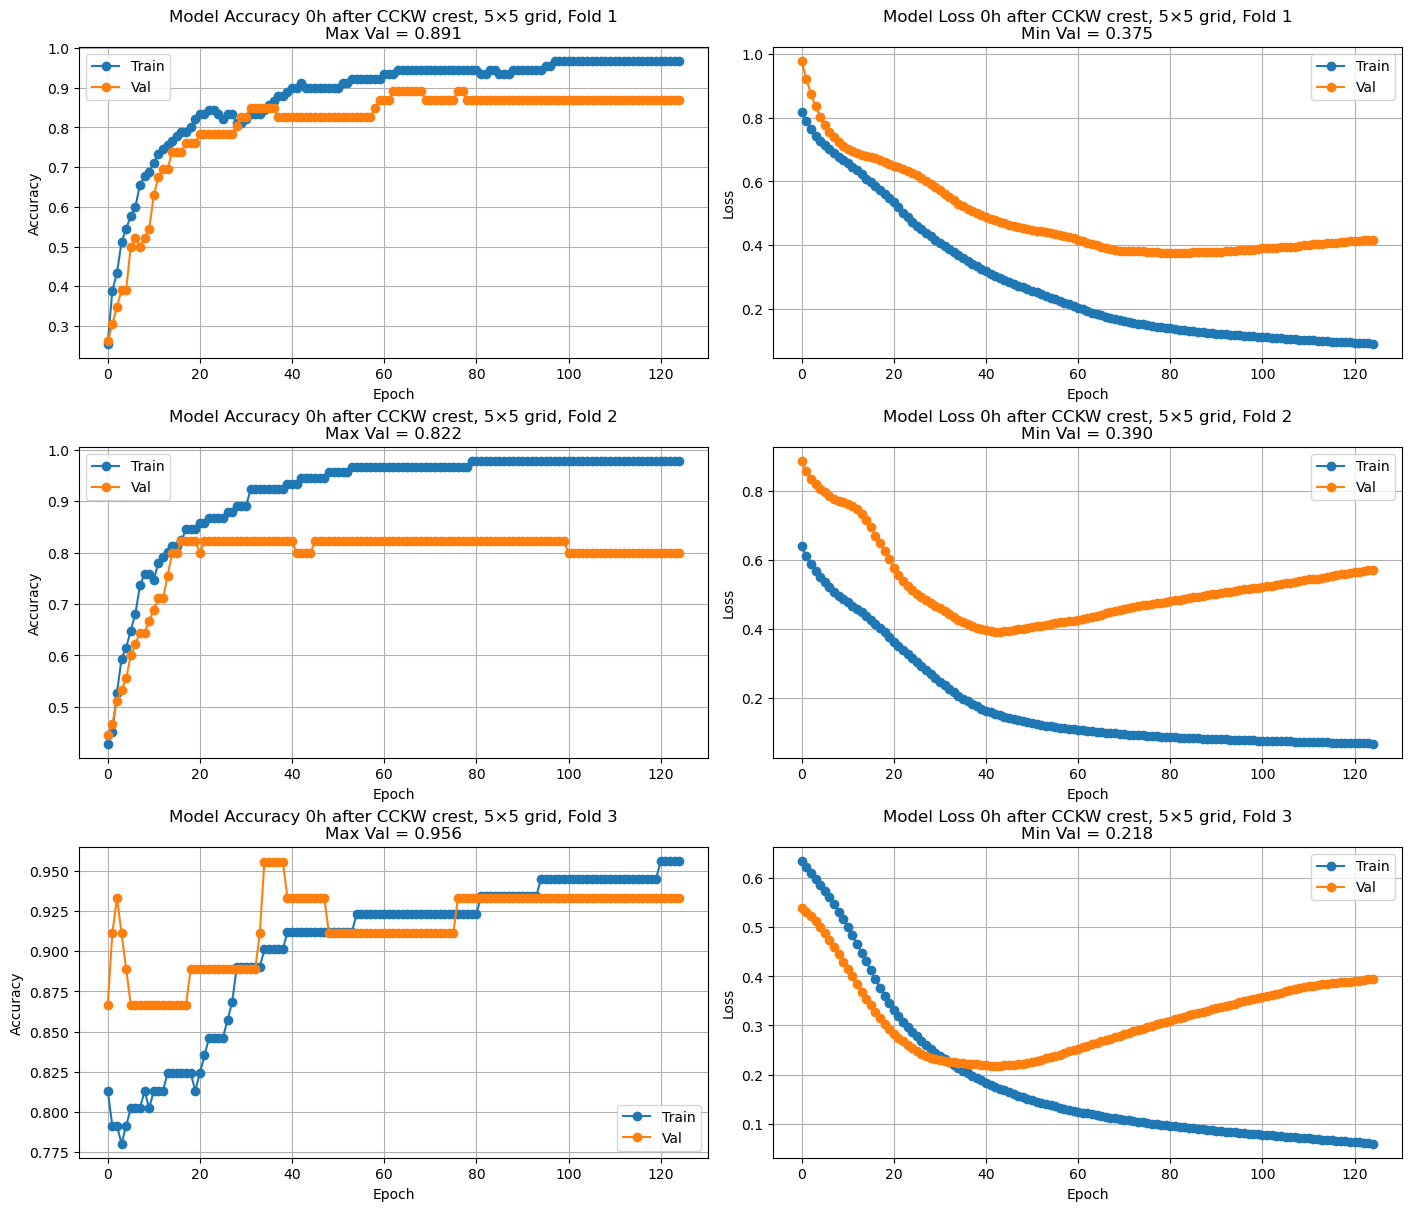

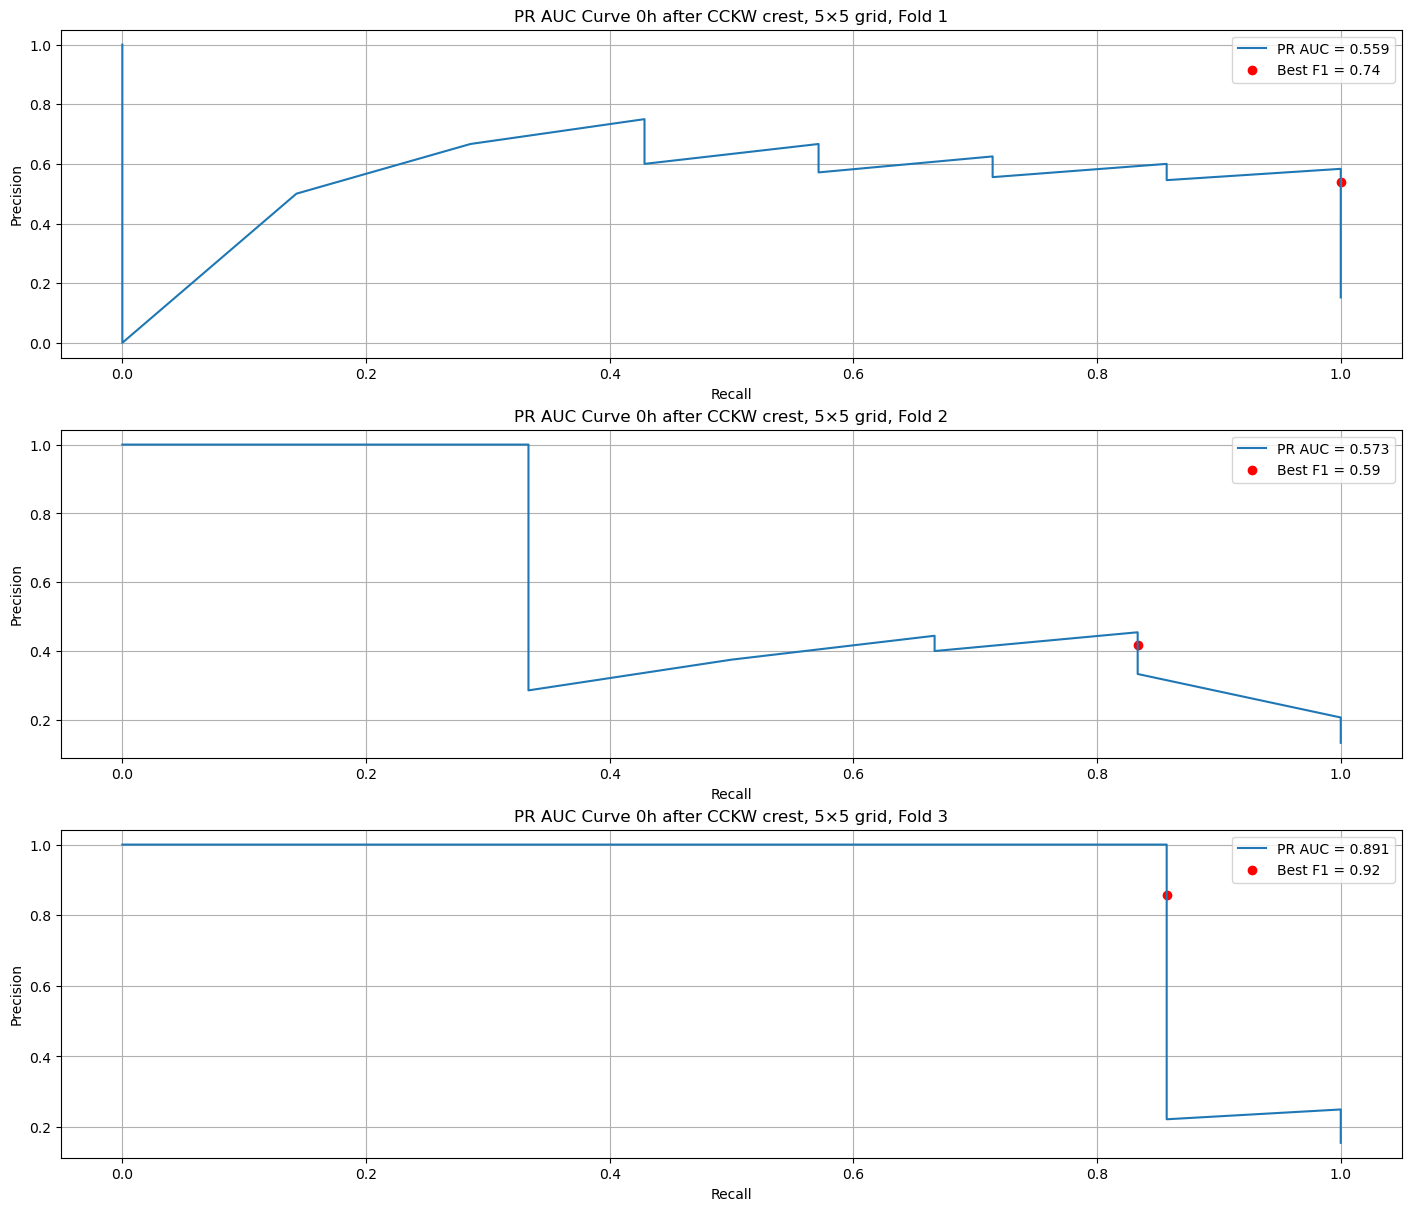

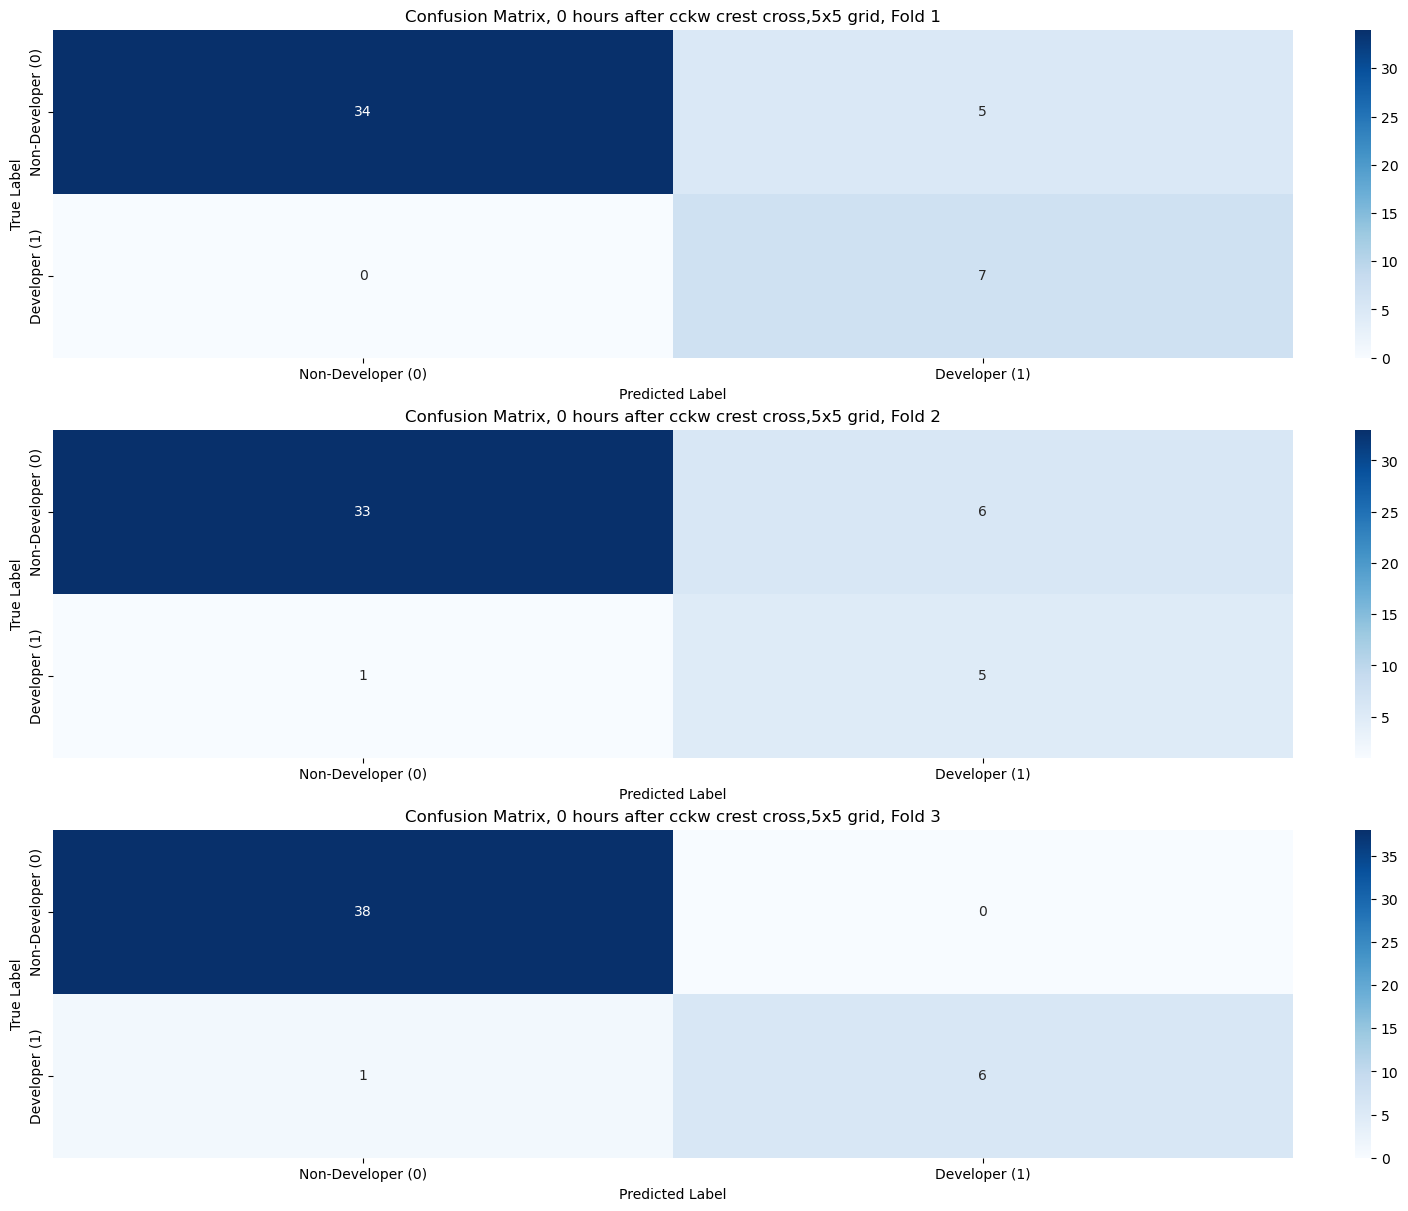

In [28]:
#SUNNY - IT WOULD BE WORTH YOUR TIME TO GO THROUGH THIS IN DETAIL AND MAKE SURE YOU DIDN'T MAKE ANY TYPOS OR MISTAKES! 

max_val_acc_list = [] 
min_val_loss_list = []
dev_F1_score_list = []
PR_AUC_list = []
threshold_list = [] 


#We are doing a lot in this code block 
#Split training dataset into k number of training and validation subsets 
#Train on the training subset, and evaluate performance on the validation subset 
#Performance evaluation metrics: max_accuracy, 


def set_seeds(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
set_seeds(42)

k = 3
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fig, axes = plt.subplots(k, 2, figsize=(14, 4 * k), constrained_layout=True)
fig2,axes2 = plt.subplots(k,1,figsize=(14, 4 * k), constrained_layout=True)
fig3,axes3 = plt.subplots(k,1,figsize=(14, 4 * k), constrained_layout=True)


# 4. Iterate over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"🌀 Fold {fold}")
    X_train_sub, X_val_sub = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_sub, y_val_sub = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = () 
    
    # Determine the input dimension (# of features)
    input_dim = X_train_sub.shape[1]
    
    model = Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        Dense(7, activation='relu', name='input'),
        Dense(2, activation='relu', name='hidden_layer_3'),
        Dense(1, activation='sigmoid', name='output_layer')  # Sigmoid for binary classification.
    ])
    
    # Create an optimizer with a custom learning rate
    optimizer = Adam(learning_rate=0.0045)   # <-- Set your learning rate here
    
    # Then compile your model using this optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Assuming y_train contains your training labels
    classes = np.unique(y_train_sub.astype(int))  # Ensure integer class labels
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_sub.astype(int))
    class_weight_dict = dict(zip(classes, class_weights))


    
    ckpt = ModelCheckpoint('best_weights.weights.h5',
                           monitor='val_accuracy',
                           mode='max',
                           save_best_only=True,      # only overwrite when val_loss improves
                           save_weights_only=True)
    
    # 1. Create reproducible training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_sub, y_train_sub))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train_sub), seed=42, reshuffle_each_iteration=False)
    train_dataset = train_dataset.batch(32)
    
    # 2. Validation dataset (no need to shuffle)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_sub, y_val_sub)).batch(32)
    
    # 3. Fit the model deterministically
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=125,
        class_weight=class_weight_dict,
        verbose=0,
        callbacks=[ckpt]
    )





    #Compute fold‑specific stats
    min_val_loss = np.min(history.history['val_loss'])
    max_val_acc  = np.max(history.history['val_accuracy'])

    #Plot model accuracy and validation curves 
    ax_acc = axes[fold-1, 0]
    ax_acc.plot(history.history['accuracy'],     marker='o', label='Train')
    ax_acc.plot(history.history['val_accuracy'], marker='o', label='Val')
    ax_acc.set_title(f"Model Accuracy {dt_cckw_cross_hrs}h after CCKW crest, {half_n*2+1}×{half_n*2+1} grid, Fold {fold}\nMax Val = {max_val_acc:.3f}")
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.legend()
    ax_acc.grid(True)

    ax_loss = axes[fold-1, 1]
    ax_loss.plot(history.history['loss'],     marker='o', label='Train')
    ax_loss.plot(history.history['val_loss'], marker='o', label='Val')
    ax_loss.set_title(f"Model Loss {dt_cckw_cross_hrs}h after CCKW crest, {half_n*2+1}×{half_n*2+1} grid, Fold {fold}\nMin Val = {min_val_loss:.3f}")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()
    ax_loss.grid(True)

    #Now let's plot PR AUC Curves 
    #First let's load optimal model weights
    model.load_weights('best_weights.weights.h5')

    y_val_pred_probs = model.predict(X_val_sub)

    # 1. Compute Precision, Recall, Thresholds
    precision, recall, thresholds = precision_recall_curve(y_val_sub, y_val_pred_probs)
    
    # 2. Compute PR AUC
    pr_auc = auc(recall, precision)
    print(f"PR AUC: {pr_auc:.4f}")
    
    # 3. Compute F1 at each threshold
    f1_scores = 2 * (precision[1:] * recall[1:]) / (precision[1:] + recall[1:] + 1e-8)
    
    # 4. Find best threshold
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    print(f"Best F1: {best_f1:.4f} at threshold {best_threshold:.4f}")

    # 5. Plot PR curve
    ax_acc2 = axes2[fold-1]
    ax_acc2.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
    ax_acc2.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best F1 = {best_f1:.2f}')
    ax_acc2.set_xlabel('Recall')
    ax_acc2.set_ylabel('Precision')
    ax_acc2.set_title(f"PR AUC Curve {dt_cckw_cross_hrs}h after CCKW crest, {half_n*2+1}×{half_n*2+1} grid, Fold {fold}")
    ax_acc2.legend()
    ax_acc2.grid(True)

    
    # --- Generate Predictions ---
    # Predict the probabilities on the test set. 
    # Note: For binary classification with a sigmoid output, the output is a probability.
    y_val_pred = model.predict(X_val_sub)
    
    # Convert probabilities to binary predictions using a threshold (default 0.5)
    y_pred = (y_val_pred > best_threshold).astype(int)
    
    # If your predictions are in a 2D array (e.g., shape (n, 1)) you might want to flatten them:
    y_pred = y_pred.ravel()
    
    # --- Examine Distribution in the Test Set ---
    print("Validation set class distribution:")
    print(y_val_sub.value_counts())
    
    # --- Confusion Matrix ---
    cm = confusion_matrix(y_val_sub, y_pred)

    ax_acc3 = axes3[fold-1]

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Non-Developer (0)', 'Developer (1)'],
                yticklabels=['Non-Developer (0)', 'Developer (1)'],
                ax=ax_acc3)
    ax_acc3.set_xlabel('Predicted Label')
    ax_acc3.set_ylabel('True Label')
    ax_acc3.set_title(f'Confusion Matrix, {dt_cckw_cross_hrs} hours after cckw crest cross,{half_n*2 +1 }x{half_n*2 + 1 } grid, Fold {fold}')

    max_val_acc_list.append(max_val_acc)
    min_val_loss_list.append(min_val_loss)
    dev_F1_score_list.append(best_f1)
    PR_AUC_list.append(pr_auc)
    threshold_list.append(best_threshold)

    #Generate and save off classification reports for each confusion matrix 
    report = classification_report(y_val_sub, y_pred, target_names=['Non-Developer', 'Developer'])
    print("Classification Report:")
    print(report)
    
    
    # 2) Choose where to save it
    outdir = "ANN_Figures/Training_and_Validation_Figures"
    os.makedirs(outdir, exist_ok=True)
    filepath = os.path.join(outdir, f"classification_report_{dt_cckw_cross_hrs}h_grid{half_n*2+1}_Fold {fold}.txt")
    
    # 3) Write it to disk
    with open(filepath, "w") as f:
        f.write("Classification Report:\n")
        f.write(report)

    #print(f"Saved classification report to {filepath}")






outdir = "ANN_Figures/Training_and_Validation_Figures"
os.makedirs(outdir, exist_ok=True)
fname = f"model_validation_accuracy_and_loss_{dt_cckw_cross_hrs}h_grid{half_n*2+1}_allfolds.png"
fig.savefig(os.path.join(outdir, fname), dpi=100, bbox_inches="tight")
fname = f"model_validation_PR_AUC_Curve_{dt_cckw_cross_hrs}h_grid{half_n*2+1}_allfolds.png"
fig2.savefig(os.path.join(outdir, fname), dpi=100, bbox_inches="tight")
fname = f"confusion_matrix_{dt_cckw_cross_hrs}h_grid{half_n*2+1}.png"
fig3.savefig(os.path.join(outdir, fname), dpi=100, bbox_inches="tight")


# After the loop, adjust layout and save/show once
fig.show()
fig2.show()
fig3.show()
    





In [78]:
#Write and save off key validation data 


print(max_val_acc_list)
# print(min_val_loss_list)
print(dev_F1_score_list)
# print(PR_AUC_list)
# print(threshold_list)

mean_max_val_acc = np.mean(max_val_acc_list)
std_max_val_acc = np.std(max_val_acc_list)

print(mean_max_val_acc)
print(std_max_val_acc)


mean_min_val_loss = np.mean(min_val_loss_list)
std_min_val_loss = np.std(max_val_acc_list)

mean_dev_F1_score = np.mean(dev_F1_score_list)
std_dev_F1_score = np.std(dev_F1_score_list)

mean_PR_AUC = np.mean(PR_AUC_list)
std_PR_AUC = np.std(PR_AUC_list)

mean_threshold = np.mean(threshold_list)
std_threshold = np.std(threshold_list)


# #Save off model metrics to csv for later analysis 

# # Sample values
# grid_size = f"{half_n*2+1}×{half_n*2+1} grid"
# time_after_cckw_cross = dt_cckw_cross_hrs

# csv_file = "model_validation_metrics_draft.csv"

# # Check if the file exists already
# file_exists = os.path.isfile(csv_file)

# # Open the file in append mode and write headers only if it's new
# with open(csv_file, mode="a", newline="") as file:
#     writer = csv.writer(file)



    
#     # Write header if file doesn't already exist
#     if not file_exists:
#         writer.writerow(["grid_size", "time_after_cckw_cross", "mean_max_val_accuracy", "std_dev_max_val_accuracy",
#                         "mean_min_validation_loss","std_dev_min_validation_loss","mean_developer_F1_score","std_dev_developer_F1_score","mean_PR_AUC","std_PR_AUC","mean_optimal_threshold","std_optimal_threshold"])
    
#     # Write the new row
#     writer.writerow([grid_size, time_after_cckw_cross, mean_max_val_acc, std_max_val_acc, mean_min_val_loss, std_min_val_loss, mean_dev_F1_score, std_dev_F1_score, mean_PR_AUC, std_PR_AUC, mean_threshold, std_threshold])
    

[0.8913043737411499, 0.8222222328186035, 0.9555555582046509]
[0.7368421006094183, 0.5882352895501731, 0.9230769181065088]
0.8896940549214681
0.05444501054367402


In [181]:
class_weights

array([0.58455882, 3.45652174])

In [79]:
#Now that we've done our k-fold cross validation, let's run the model on the test set and see what results we get! 

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

model = () 

# Determine the input dimension (# of features)
input_dim = X_train.shape[1]

set_seeds(42)

model = Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    Dense(7, activation='relu', name='input'),
    Dense(2, activation='relu', name='hidden_layer_1'),
    Dense(1, activation='sigmoid', name='output_layer')  # Sigmoid for binary classification.
])

# Create an optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0045)   # <-- Set your learning rate here

# Then compile your model using this optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Assuming y_train contains your training labels
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)
#class_weight_dict = {0.0: 0.5, 1.0: 5} #alt weights
set_seeds(42)

ckpt = ModelCheckpoint('best_full_train_weights.weights.h5',
                       monitor='val_accuracy',
                       mode='max',
                       save_best_only=True,      # only overwrite when val_loss improves
                       save_weights_only=True)

# Fit the model using class weights
history = model.fit(X_train, y_train,
                    epochs=125,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    class_weight=class_weight_dict,
                    verbose=1,shuffle=True,callbacks=[ckpt]
)

Class weights: {0.0: 0.5845588235294118, 1.0: 3.4565217391304346}
Epoch 1/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.2873 - loss: 0.8672 - val_accuracy: 0.3913 - val_loss: 0.9119
Epoch 2/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3450 - loss: 0.8162 - val_accuracy: 0.4348 - val_loss: 0.8437
Epoch 3/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4637 - loss: 0.7808 - val_accuracy: 0.5072 - val_loss: 0.7927
Epoch 4/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5253 - loss: 0.7583 - val_accuracy: 0.5797 - val_loss: 0.7542
Epoch 5/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5755 - loss: 0.7419 - val_accuracy: 0.6377 - val_loss: 0.7270
Epoch 6/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6439 - loss: 0.7286 - val_accuracy: 0.6667 - val_loss: 0.7060
Epoch 7/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6610 - loss: 0.7176 - val_accuracy: 0.7246 - val_loss: 0.6898
Epoch 8/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step -

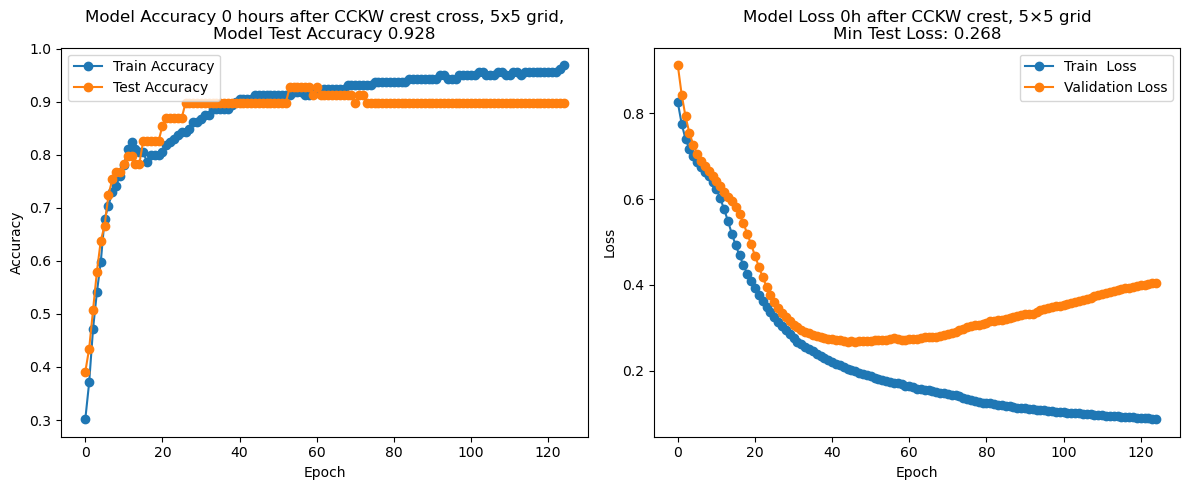

In [80]:
#Let's make plots of the test data results! 

min_test_loss = np.min(history.history['val_loss']) 
max_test_accuracy = np.max(history.history['val_accuracy'])

# --- Plot Accuracy and Loss ---
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='o')

plt.title(f"Model Accuracy {dt_cckw_cross_hrs} hours after CCKW crest cross, "
          f"{half_n*2+1}x{half_n*2+1} grid,\n" 
          f"Model Test Accuracy {max_test_accuracy:.3f}")


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train  Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title(
    f"Model Loss {dt_cckw_cross_hrs}h after CCKW crest, {half_n*2+1}×{half_n*2+1} grid\n"
    f"Min Test Loss: {min_test_loss:.3f}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

# make sure your output directory exists
outdir = "ANN_Figures/Test_Data_Figures"
os.makedirs(outdir, exist_ok=True)

# construct a filename
fname = f"model_accuracy_and_loss_{dt_cckw_cross_hrs}h_grid{half_n*2+1}.png"

# # save the current figure
# plt.savefig(
#     os.path.join(outdir, fname),
#     dpi=300,               # resolution
#     bbox_inches="tight"    # trim extra whitespace
# )

# plt.show()


In [ ]:
#Parameters from cross validation to use for the test set 

#mean threshold 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test set class distribution:
developer
0.0    59
1.0    10
Name: count, dtype: int64


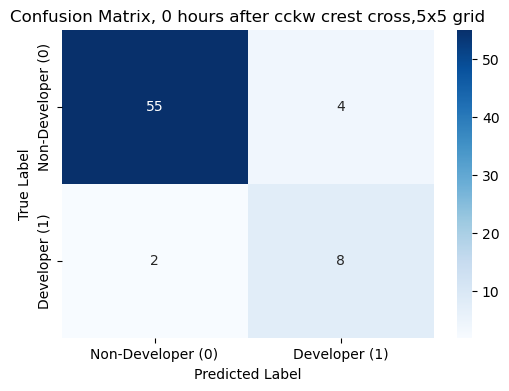

Classification Report:
               precision    recall  f1-score   support

Non-Developer       0.96      0.93      0.95        59
    Developer       0.67      0.80      0.73        10

     accuracy                           0.91        69
    macro avg       0.82      0.87      0.84        69
 weighted avg       0.92      0.91      0.92        69

Saved classification report to ANN_Figures/Test_Data_Figures/classification_report_0h_grid5.txt


In [81]:
#Load weights with best training loss performance 
model.load_weights('best_full_train_weights.weights.h5')

# --- Generate Predictions ---
# Predict the probabilities on the test set. 
# Note: For binary classification with a sigmoid output, the output is a probability.
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary predictions using a threshold (default 0.5)
y_pred = (y_pred_probs > mean_threshold).astype(int)

# If your predictions are in a 2D array (e.g., shape (n, 1)) you might want to flatten them:
y_pred = y_pred.ravel()

# --- Examine Distribution in the Test Set ---
print("Test set class distribution:")
print(y_test.value_counts())

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Developer (0)', 'Developer (1)'],
            yticklabels=['Non-Developer (0)', 'Developer (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix, {dt_cckw_cross_hrs} hours after cckw crest cross,{half_n*2 +1 }x{half_n*2 + 1 } grid')


# make sure your output directory exists
outdir = "ANN_Figures/Test_Data_Figures"
os.makedirs(outdir, exist_ok=True)

# construct a filename
fname = f"confusion_matrix_{dt_cckw_cross_hrs}h_grid{half_n*2+1}.png"

# save the current figure
plt.savefig(
    os.path.join(outdir, fname),
    dpi=300,               # resolution
    bbox_inches="tight"    # trim extra whitespace
)

plt.show()

# --- Classification Report ---
report = classification_report(y_test, y_pred, target_names=['Non-Developer', 'Developer'])
print("Classification Report:")
print(report)


# 2) Choose where to save it
outdir = "ANN_Figures/Test_Data_Figures"
os.makedirs(outdir, exist_ok=True)
filepath = os.path.join(outdir, f"classification_report_{dt_cckw_cross_hrs}h_grid{half_n*2+1}.txt")

# 3) Write it to disk
with open(filepath, "w") as f:
    f.write("Classification Report:\n")
    f.write(report)

print(f"Saved classification report to {filepath}")

In [82]:
#Now let's plot PR AUC Curves 
#First let's load optimal model weights
model.load_weights('best_full_train_weights.weights.h5')

# 1. Compute Precision, Recall, Thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# 2. Compute PR AUC
pr_auc_test = auc(recall, precision)
print(f"PR AUC: {pr_auc:.4f}")

#Extract Developer F1 Score 
# --- Classification Report ---
report = classification_report(y_test, y_pred, target_names=['Non-Developer', 'Developer'],output_dict=True)
f1_score_test = report['Developer']['f1-score']
print(f"Test Set F1 Developer Score {f1_score_test}")



#Don't need to plot here bc we're no longer "optimizing" ( but keeping code here for rn)

# # 4. Find best threshold
# best_idx = np.argmax(f1_scores)
# best_threshold = thresholds[best_idx]
# best_f1 = f1_scores[best_idx]
# print(f"Best F1: {best_f1:.4f} at threshold {best_threshold:.4f}")

# # 5. Plot PR curve
# fig,ax = plt.subplots()

# ax.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
# ax.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best F1 = {best_f1:.2f}')
# ax.set_xlabel('Recall')
# ax.set_ylabel('Precision')
# ax.set_title(f"PR AUC Curve {dt_cckw_cross_hrs}h after CCKW crest, {half_n*2+1}×{half_n*2+1} grid, Test Set")
# ax.legend()
# ax.grid(True)

# plt.show()


PR AUC: 0.8062
Test Set F1 Developer Score 0.7272727272727273


In [85]:
#Save off model metrics to csv for later analysis 

# Sample values
grid_size = f"{half_n*2+1}×{half_n*2+1} grid"
time_after_cckw_cross = dt_cckw_cross_hrs

csv_file = "model_validation_metrics_draft.csv"

# Check if the file exists already
file_exists = os.path.isfile(csv_file)

# Open the file in append mode and write headers only if it's new
with open(csv_file, mode="a", newline="") as file:
    writer = csv.writer(file)
    
    # Write header if file doesn't already exist
    if not file_exists:
        writer.writerow(["grid_size", "time_after_cckw_cross", "mean_max_val_accuracy", "std_dev_max_val_accuracy",
                        "mean_min_validation_loss","std_dev_min_validation_loss","mean_developer_F1_score","std_dev_developer_F1_score","mean_PR_AUC","std_PR_AUC","mean_optimal_threshold","std_optimal_threshold",
                        "max_test_accuracy","min_test_loss","test_PR_AUC","test_f1_score"
                        
                        ])
    
    # Write the new row
    writer.writerow([grid_size, time_after_cckw_cross, mean_max_val_acc, std_max_val_acc, mean_min_val_loss, std_min_val_loss, mean_dev_F1_score, std_dev_F1_score, mean_PR_AUC, std_PR_AUC, mean_threshold, std_threshold,
                    max_test_accuracy,min_test_loss,pr_auc_test,f1_score_test])
    


# #Let's save off test data in the spreadsheet! 

# # Open the file in append mode and write headers only if it's new
# with open(csv_file, mode="a") as file:
#     writer = csv.writer(file)


    
#     # Write header if file doesn't already exist
#     if not file_exists:
#         writer.writerow(["max_test_accuracy","min_test_loss","test_PR_AUC","test_f1_score"])
    
#     # Write the new row
#     writer.writerow([max_test_accuracy,min_test_loss,pr_auc_test,f1_score_test])
    

In [44]:
#Let's figure out which data points the model missed (and why) 

y_pred_series = pd.Series(
    y_pred,
    index=y_test.index,
    name='y_pred'
)


fp_idx = y_pred_series[(y_pred_series == 1) & (y_test == 0)].index
fn_idx = y_pred_series[(y_pred_series == 0) & (y_test == 1)].index

print(fp_idx)
print(fn_idx)

fp_df = X_test.loc[fp_idx].copy()
fn_df = X_test.loc[fn_idx].copy()
fp_df['error_type'] = 'False Positive'
fn_df['error_type'] = 'False Negative'
fp_df['sample_id']  = fp_df.index.astype(str)   # string so seaborn treats it categorically
fn_df['sample_id']  = fn_df.index.astype(str)

# Combine them
mis_df = pd.concat([fp_df, fn_df], axis=0)



# Melt so you get one row per sample×variable
mis_melted = mis_df.melt(
    id_vars=['error_type','sample_id'],
    value_vars=list(feature_cols),
    var_name='Variable',
    value_name='Anomaly Value'
)

mis_melted

Index([47, 209, 143, 107], dtype='int64')
Index([1, 28], dtype='int64')


,error_type,sample_id,Variable,Anomaly Value
0,False Positive,47,olrtoa_anomaly,-2.035987
1,False Positive,209,olrtoa_anomaly,-0.700580
2,False Positive,143,olrtoa_anomaly,-1.586533
3,False Positive,107,olrtoa_anomaly,-1.098477
4,False Negative,1,olrtoa_anomaly,-2.086866
5,False Negative,28,olrtoa_anomaly,-0.548792
6,False Positive,47,u200_anomaly,0.764035
7,False Positive,209,u200_anomaly,-0.241559
8,False Positive,143,u200_anomaly,0.498347
9,False Positive,107,u200_anomaly,0.351726


In [46]:
mis_melted['Scaled'] = (
    mis_melted
      .groupby('Variable')['Anomaly Value']
      .transform(lambda x: (x - x.mean()) / x.std())
)

# First map 0 -> 'Non-Developer', 1 -> 'Developer'
merged_cckw_full['developer_label'] = merged_cckw_full['developer'].map({0: 'Non-Developer', 1: 'Developer'})
# Melt

melted = merged_cckw_full.melt(id_vars='developer_label', value_vars=X_test,var_name='Variable', value_name='Anomaly Value')

# after you’ve created your `melted` DataFrame:

melted['Scaled'] = (
    melted
      .groupby('Variable')['Anomaly Value']
      .transform(lambda x: (x - x.mean()) / x.std())
)



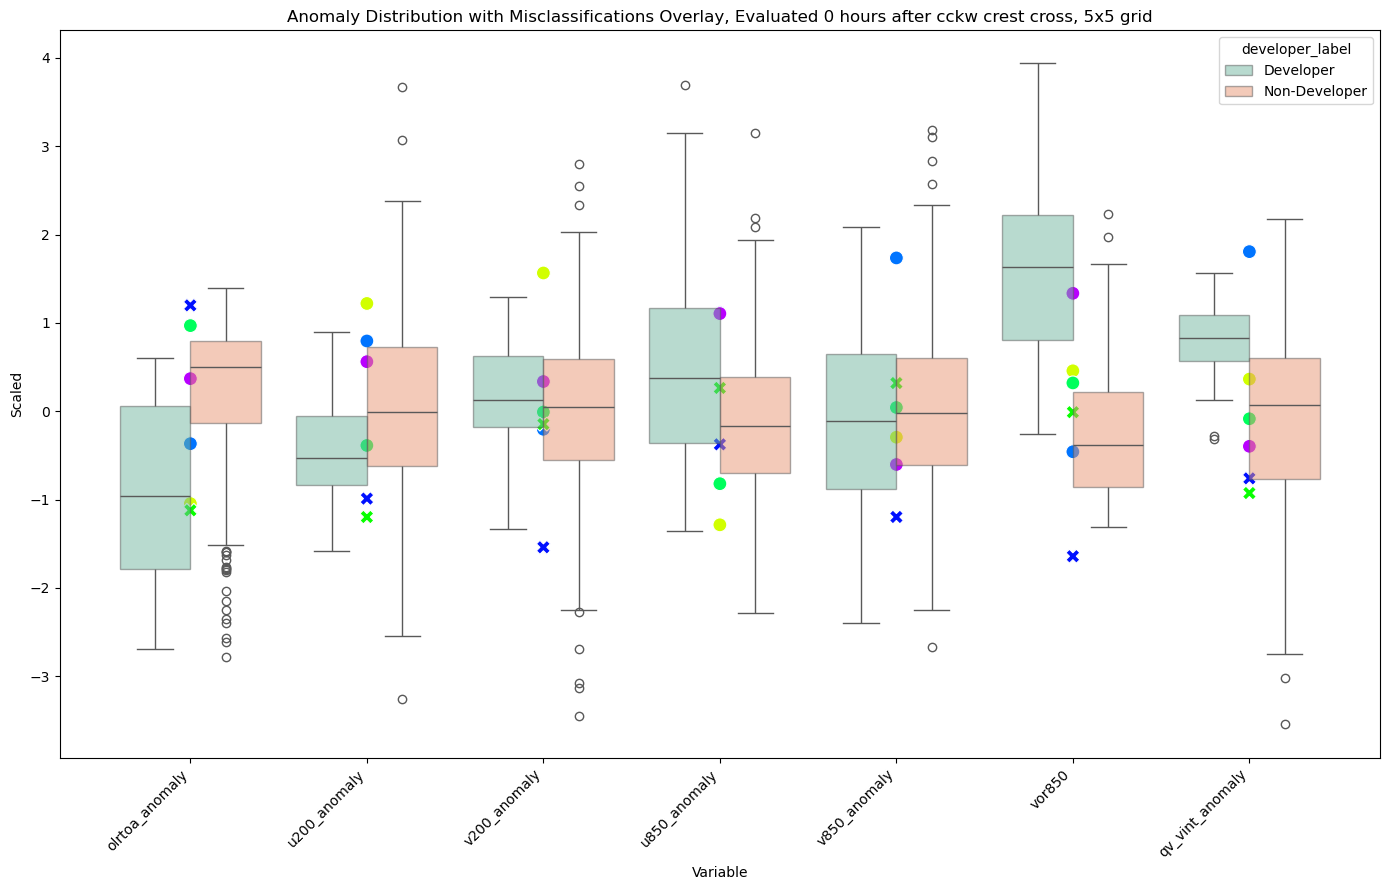

In [50]:
plt.figure(figsize=(14,9))

# 1) your original boxplot
sns.boxplot(
    data=melted,
    x='Variable',
    y='Scaled',
    hue='developer_label',
    palette='Set2',
    boxprops={'alpha': 0.5}   # <-- make boxes 30% opaque

)

# scatter of all FPs, each with its own hue
fp_only = mis_melted[mis_melted['error_type']=='False Positive']
sns.scatterplot(
    data=fp_only,
    x='Variable', y='Scaled',
    hue='sample_id',         # <–– each sample_id gets its own color
    palette='hsv',           # or 'tab20', 'gist_rainbow', etc.
    marker='o',
    s=100,
    legend=False,            # hide the huge legend, or set True if you want it
    label='False Positive'

)

# scatter of FNs each with its own hue
fn_only = mis_melted[mis_melted['error_type']=='False Negative']
sns.scatterplot(
    data=fn_only,
    x='Variable', y='Scaled',
    hue='sample_id',           # or whatever you like
    marker='X',
    palette='hsv',           # or 'tab20', 'gist_rainbow', etc.
    s=100,
    legend=False,
    label='False Positive'

)


plt.title(f'Anomaly Distribution with Misclassifications Overlay, Evaluated {dt_cckw_cross_hrs} hours after cckw crest cross, {half_n*2 +1 }x{half_n*2 + 1 } grid')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# make sure your output directory exists
outdir = "ANN_Figures/Test_Data_Figures"
os.makedirs(outdir, exist_ok=True)

# construct a filename
fname = f"anomaly distribution {dt_cckw_cross_hrs}h_grid{half_n*2+1}.png"

# save the current figure
plt.savefig(
    os.path.join(outdir, fname),
    dpi=300,               # resolution
    bbox_inches="tight"    # trim extra whitespace
)

plt.show()


In [98]:
dev_probability = len(y[y==1])/len(y[y==0])
dev_probability

0.16923076923076924

In [117]:
#Create your baseline model (16% of cases are developers) 
def generate_y(N, p_dev=0.16, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # each entry is 1 with prob p_dev, 0 otherwise
    y = np.random.binomial(1, p_dev, size=N)
    return y

# example
y = generate_y(len(y_test), p_dev=0.16, seed=42)
print(f"Fraction of developers: {y.mean():.3f}")  # ~0.16


Fraction of developers: 0.217


In [113]:
#Extract Developer F1 Score 
# --- Classification Report ---
report = classification_report(y_test, y_pred, target_names=['Non-Developer', 'Developer'],output_dict=True)
f1_score_test = report['Developer']['f1-score']
print(f"Test Set F1 Developer Score {f1_score_test}")

Test Set F1 Developer Score 0.7272727272727273


In [131]:
# Get confidence interval on model test set F1 compared to a probability based statistical model! 


def stratified_paired_bootstrap(y_true, y_pred_a, y_pred_b, B=2000, seed=None):
    rng     = np.random.default_rng(seed)
    N       = len(y_true)
    
    # 1. split indices by class
    pos_idx = np.where(y_true == 1)[0]
    neg_idx = np.where(y_true == 0)[0]
    n_pos   = len(pos_idx)
    n_neg   = len(neg_idx)
    
    deltas = np.empty(B)
    for b in range(B):
        # 2. sample WITH replacement within each class
        boot_pos = rng.choice(pos_idx, size=n_pos, replace=True)
        boot_neg = rng.choice(neg_idx, size=n_neg, replace=True)
        boot_idx = np.concatenate([boot_pos, boot_neg])
        
        # 3. evaluate both models on that stratified sample
        y_b      = y_true[boot_idx]
        a_b      = y_pred_a[boot_idx]
        b_b      = y_pred_b[boot_idx]
        f1_a     = f1_score(y_b, a_b)
        f1_b     = f1_score(y_b, b_b)
        
        deltas[b] = f1_a - f1_b
    
    # 4. compute p‑value & CI
    p_value = np.mean(deltas <= 0)                   # one‑sided test
    ci_low, ci_high = np.percentile(deltas, [2.5, 97.5])
    return p_value, (ci_low, ci_high), deltas

# usage:
p, (lo, hi), deltas = stratified_paired_bootstrap(
    y_test.values, y_pred, y, B=5000, seed=42
)
print(f"p = {p:.3f}, 95% CI ΔF₁ = [{lo:.3f}, {hi:.3f}]")


p = 0.002, 95% CI ΔF₁ = [0.167, 0.776]


Setting up imputer for keras model, assuming that any necessary output activations are applied properly. If not, please set up keras.Sequential with keras.layers.Softmax()


  0%|          | 0/1 [00:00<?, ?it/s]

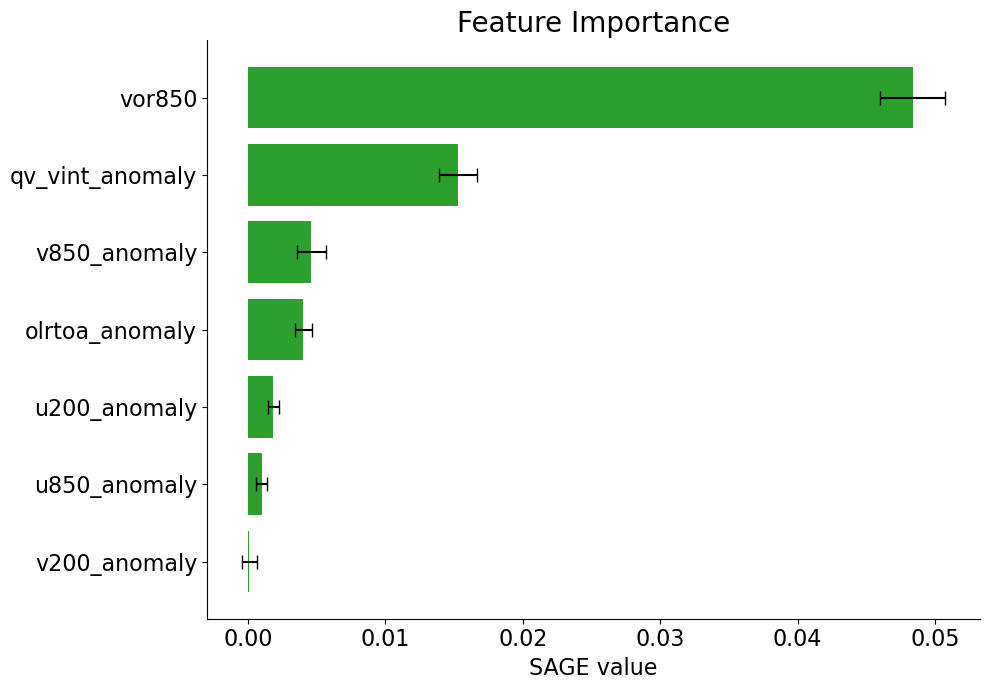

In [186]:
#Quick global feature importance setup 


from sage import MarginalImputer, PermutationEstimator

X_train_vals = X_train.values
y_train_vals = y_train.values


# ─── 2) Instantiate the imputer ────────────────────
imputer = MarginalImputer(model, X_train_vals)

# ─── 3) Instantiate the estimator ──────────────────
# Here we’re using mean-squared-error loss for regression
estimator = PermutationEstimator(imputer, loss="mse")

# ─── 4) Compute SAGE values ────────────────────────
sage_values = estimator(X_train_vals, y_train_vals)  # returns a SAGEValues object

# ─── 5) (Optional) Plot or inspect ─────────────────
sage_values.plot(feature_names=X_train.columns, error_bars=True)